In [1]:
fmodel = '/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/02_Integration/models/scanvi_model_cuda_allvars'
fdata = '/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/02_Integration/adata/adata_GenAnno_allvars.h5ad'

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi 

/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad(fdata)

In [4]:
model = scvi.model.SCANVI.load(fmodel, adata)

INFO     File /home/igarzonalva/Proyecto_SC_TNBC/GSE161529/02_Integration/models/scanvi_model_cuda_allvars/model.pt
         already downloaded                                                                                        


/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/home/igarzonalva/.conda/envs/scvi_cpu_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightn

In [6]:
predictions = model.predict(soft = True)

In [7]:
max_probs = predictions.max(axis=1)
assigned_ct = predictions.idxmax(axis=1)
cell_type_predictions = pd.DataFrame(data={'prediction':assigned_ct.values,'probability': max_probs.values}, 
                 index= assigned_ct.index)
cell_type_predictions

,prediction,probability
AAACCTGCAAGCGTAG-1-GSM4909281,T cells,0.999999
AAACCTGCAATAGAGT-1-GSM4909281,Cycling Epithelial,0.999808
AAACCTGCAATTGCTG-1-GSM4909281,Epithelial,0.999581
AAACCTGCACTCAGGC-1-GSM4909281,Endothelial,0.829421
AAACCTGCAGTGACAG-1-GSM4909281,Endothelial,1.000000
...,...,...
TTTGTTGGTGGGTATG-1-GSM4909317,Epithelial,0.999983
TTTGTTGTCACTTTGT-1-GSM4909317,Epithelial,0.597713
TTTGTTGTCGCACGGT-1-GSM4909317,T cells,0.999999
TTTGTTGTCTCCCTAG-1-GSM4909317,MioEpithelial,1.000000


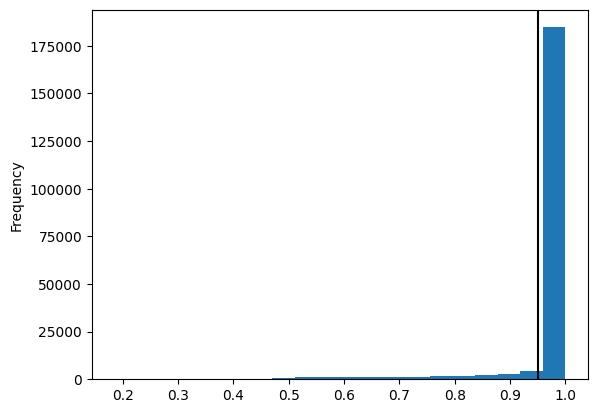

In [12]:
cell_type_predictions.probability.plot.hist(bins = 20)
plt.axvline(x=0.95,color='k')

/tmp/ipykernel_132207/7653096.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


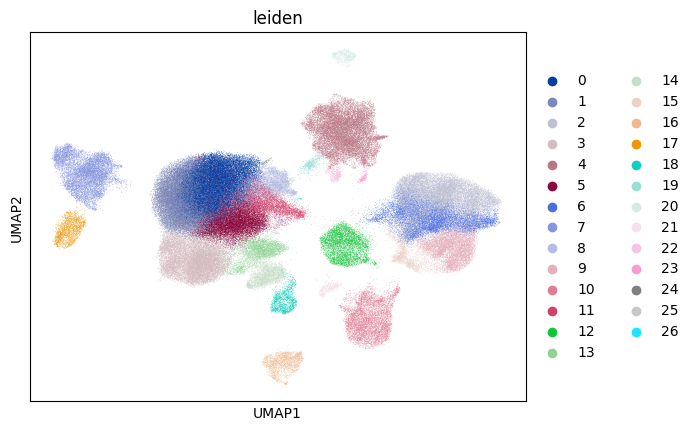

In [14]:
adata.obsm['X_scANVI'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['leiden'])

In [16]:
# Obtain batch normalized counts
corrected_data = model.get_normalized_expression(transform_batch = sorted(adata.obs['batch'].unique()), library_size = 1e4)
corrected_data.iloc[:,:] = np.log1p(corrected_data.values)
adata.layers['scanvi_batch_corrected_counts'] = corrected_data


In [17]:
adata_hvg = sc.read_h5ad('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/03_LabelTransfer/adatas/general_adata_postLT.h5ad')

In [18]:
adata_hvg

AnnData object with n_obs × n_vars = 202568 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', 'leiden', 'IGA_First_GenAnno', 'scanvi_prediction', 'IGA_PostScAnvi_GenAnno_colors', 'post_lt_anno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_PostScAnvi_GenAnno_colors_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'majority_voting_colors', 'neighbors', 'post_lt_anno_colors', 'predicted_labels_colors', 'scanvi_prediction_colors', 'subtype_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

In [19]:
adata

AnnData object with n_obs × n_vars = 205006 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'IGA_First_GenAnno', 'IGA_First_GenAnnoV2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_First_GenAnnoV2_colors', 'IGA_First_GenAnno_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'batch_corrected_counts', 'counts', 'scanvi_batch_corrected_counts'
    obsp: 'connectivities', 

In [20]:
common_cells = adata_hvg.obs_names.intersection(adata.obs_names)

In [22]:
len(common_cells)

202568

In [24]:
adata_comm_fil = adata[common_cells,:].copy()

In [25]:
adata_comm_fil

AnnData object with n_obs × n_vars = 202568 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'IGA_First_GenAnno', 'IGA_First_GenAnnoV2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_First_GenAnnoV2_colors', 'IGA_First_GenAnno_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'batch_corrected_counts', 'counts', 'scanvi_batch_corrected_counts'
    obsp: 'connectivities', 

In [27]:
adata_comm_fil.obs.loc[common_cells,'IGA_LT_Anno'] = adata_hvg.obs.loc[common_cells,'post_lt_anno']

In [28]:
adata_comm_fil

AnnData object with n_obs × n_vars = 202568 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'IGA_First_GenAnno', 'IGA_First_GenAnnoV2', 'IGA_LT_Anno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_First_GenAnnoV2_colors', 'IGA_First_GenAnno_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_scANVI'
    layers: 'batch_corrected_counts', 'counts', 'scanvi_batch_corrected_counts'
    obsp: 'co

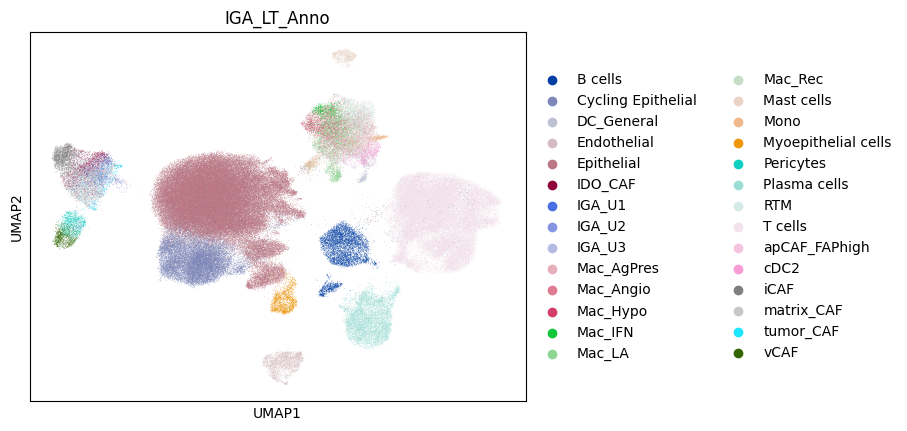

In [38]:
sc.pl.umap(adata_comm_fil, color = ['IGA_LT_Anno'])

In [33]:
adata_comm_fil.write_h5ad('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/03_LabelTransfer/adatas/general_adata_postLT_allvars')

In [36]:
adata.obs['scanvi_predictions'] = model.predict()

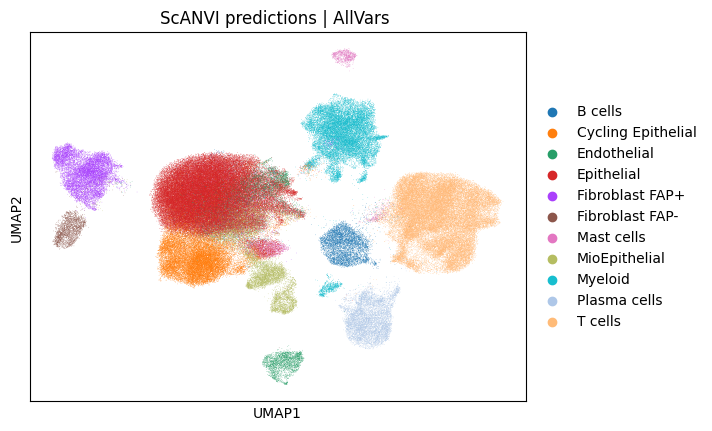

In [37]:
sc.pl.umap(adata, color = ['scanvi_predictions'], title = 'ScANVI predictions | AllVars ')